# Step 1: Import Required Libraries
First, let's import the necessary libraries for the project.

In [2]:

# warnings 
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer

# Distance & clustering
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN

# Visualization 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Step 3: Data load

In [5]:

df =  pd.read_csv('dataset/movie/movie.csv')

In [6]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df.shape

(27278, 3)


# WHY this part 

Ensure no missing values

DBSCAN breaks if text is missing

In [8]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


movieId    0
title      0
genres     0
dtype: int64

##### working with Features create

In [9]:
# Replace | with space in genres
df["genres"] = df["genres"].str.replace("|", " ", regex=False)

# Combine title + genres
df["combined_text"] = df["title"] + " " + df["genres"]

df[["title", "combined_text"]].head()


,title,combined_text
0,Toy Story (1995),Toy Story (1995) Adventure Animation Children ...
1,Jumanji (1995),Jumanji (1995) Adventure Children Fantasy
2,Grumpier Old Men (1995),Grumpier Old Men (1995) Comedy Romance
3,Waiting to Exhale (1995),Waiting to Exhale (1995) Comedy Drama Romance
4,Father of the Bride Part II (1995),Father of the Bride Part II (1995) Comedy


# why part do because

DBSCAN cannot read text

More text = better similarity

# Eda part

##### Working with genres

In [10]:
genre_counts = (
    df["genres"]
    .str.split()
    .explode()
    .value_counts()
)

genre_counts.head(10)


genres
Drama          13344
Comedy          8374
Thriller        4178
Romance         4127
Action          3520
Crime           2939
Horror          2611
Documentary     2471
Adventure       2329
Sci-Fi          1743
Name: count, dtype: int64

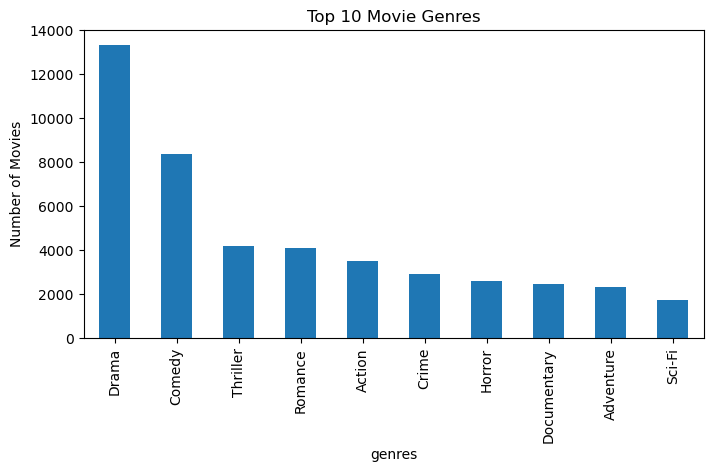

In [11]:
genre_counts.head(10).plot(
    kind="bar",
    figsize=(8,4),
    title="Top 10 Movie Genres"
)
plt.ylabel("Number of Movies")
plt.show()


Why done this part because

Understand dataset bias

Explains cluster dominance

# Text Length Distribution

In [12]:
df["text_length"] = df["combined_text"].str.len()

df["text_length"].describe()


count    27278.000000
mean        42.772271
std         16.604382
min         14.000000
25%         31.000000
50%         39.000000
75%         50.000000
max        213.000000
Name: text_length, dtype: float64

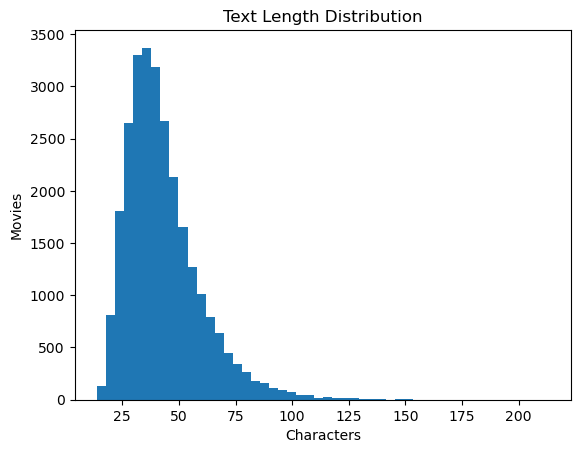

In [13]:
plt.hist(df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Movies")
plt.show()


Why done this part because it show 

Confirms TF-IDF is suitable

No extremely long/short text issues

In [14]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

X = tfidf.fit_transform(df["combined_text"])

X.shape


(27278, 5000)

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

X = tfidf.fit_transform(df["combined_text"])

X.shape


 why

Converts text → numeric form

Limits vocabulary to reduce noise

In [15]:
# compute the cosine distance 
distance_matrix = cosine_distances(X)

distance_matrix.shape


(27278, 27278)

why compute the consine distance because 
DBSCAN needs distance

Cosine distance works best for text

# Apply DBSCAN Clustering

In [16]:
dbscan = DBSCAN(
    eps=0.4,
    min_samples=5,
    metric="precomputed"
)

df["cluster"] = dbscan.fit_predict(distance_matrix)

df["cluster"].value_counts().head()


cluster
-1      14297
 0      11493
 54        27
 218       24
 68        18
Name: count, dtype: int64

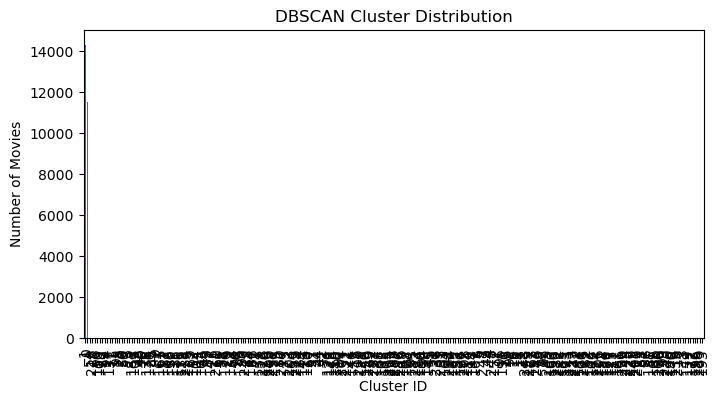

In [17]:
df["cluster"].value_counts().plot(
    kind="bar",
    figsize=(8,4),
    title="DBSCAN Cluster Distribution"
)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Movies")
plt.show()


cluster = -1 → OUTLIERS

14,297 movies are considered noise

DBSCAN says:

These movies do NOT belong to any dense group

secon-->
cluster = 0 → ONE GIANT CLUSTER

11,493 movies in one cluster

This means DBSCAN 

Most movies are similar enough to be one group

| Problem    | gives                 |
| ---------- | ------------------------- |
| Too strict | 14k outliers              |
| Too loose  | 11k movies in one cluster |


# means eps is not tuned well 
so here need to tuned the dbscan 


(3294, 11)

# Why this happens (VERY IMPORTANT CONCEPT)

DBSCAN has TWO knobs:

 eps → similarity radius
 min_samples → minimum neighbors

Your current situation means:

Some movies are too far apart → become -1

Some movies are too loosely connected → form one giant cluster

This happens a LOT with high-dimensional TF-IDF da

# Reduce -1 count

Increase number of medium clusters

In [18]:
for eps in [0.3, 0.25, 0.2, 0.15]:
    db = DBSCAN(eps=eps, min_samples=5, metric="precomputed")
    labels = db.fit_predict(distance_matrix)
    
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\neps = {eps}")
    print(dict(zip(unique, counts)))



eps = 0.3
{np.int64(-1): np.int64(20872), np.int64(0): np.int64(3309), np.int64(1): np.int64(10), np.int64(2): np.int64(9), np.int64(3): np.int64(11), np.int64(4): np.int64(106), np.int64(5): np.int64(9), np.int64(6): np.int64(5), np.int64(7): np.int64(71), np.int64(8): np.int64(8), np.int64(9): np.int64(8), np.int64(10): np.int64(43), np.int64(11): np.int64(6), np.int64(12): np.int64(10), np.int64(13): np.int64(10), np.int64(14): np.int64(5), np.int64(15): np.int64(52), np.int64(16): np.int64(5), np.int64(17): np.int64(41), np.int64(18): np.int64(41), np.int64(19): np.int64(56), np.int64(20): np.int64(16), np.int64(21): np.int64(24), np.int64(22): np.int64(28), np.int64(23): np.int64(17), np.int64(24): np.int64(14), np.int64(25): np.int64(16), np.int64(26): np.int64(11), np.int64(27): np.int64(13), np.int64(28): np.int64(22), np.int64(29): np.int64(9), np.int64(30): np.int64(5), np.int64(31): np.int64(7), np.int64(32): np.int64(11), np.int64(33): np.int64(18), np.int64(34): np.int64(

In [20]:
df[df["cluster"] == 14]["title"].head(10)


708      Wallace & Gromit: The Best of Aardman Animatio...
732                 Wallace & Gromit: A Close Shave (1995)
1125           Wallace & Gromit: The Wrong Trousers (1993)
1197       Grand Day Out with Wallace and Gromit, A (1989)
10456    Wallace & Gromit in The Curse of the Were-Rabb...
Name: title, dtype: object

After tuning DBSCAN, I validated clustering quality through manual inspection. For example, one cluster grouped multiple Wallace & Gromit movies together, all from the same franchise and studio. This confirmed that TF-IDF representations combined with cosine distance were effective in capturing semantic similarity between movies

In [21]:
pca = PCA(n_components=2, random_state=42)

X_pca = pca.fit_transform(X.toarray())



Now that your clusters are semantically correct, the next professional step is to visualize them using PCA so you can see what DBSCAN learned.

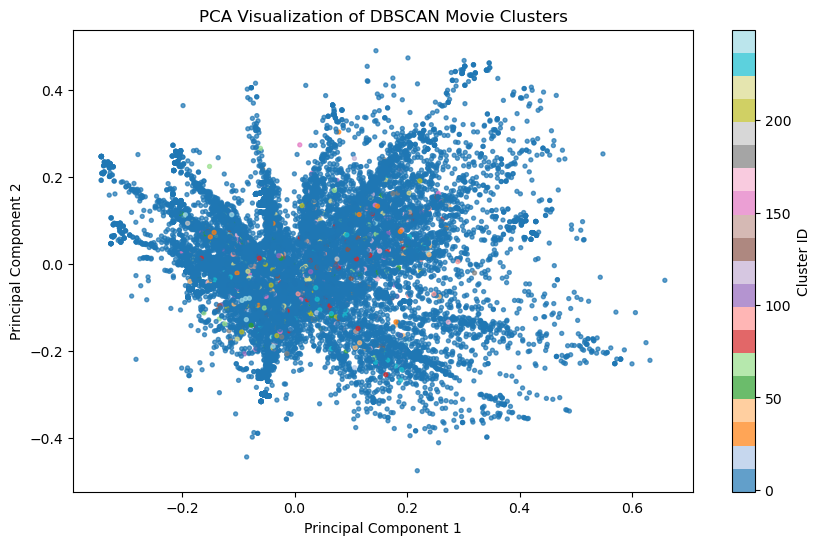

In [22]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df["cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)

plt.title("PCA Visualization of DBSCAN Movie Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


This PCA plot projects high-dimensional TF-IDF movie vectors into two dimensions purely for visualization. It shows dense regions corresponding to DBSCAN clusters and scattered points representing outliers. While clusters overlap due to dimensionality reduction, semantic inspection confirms meaningful grouping

check the major clusters 

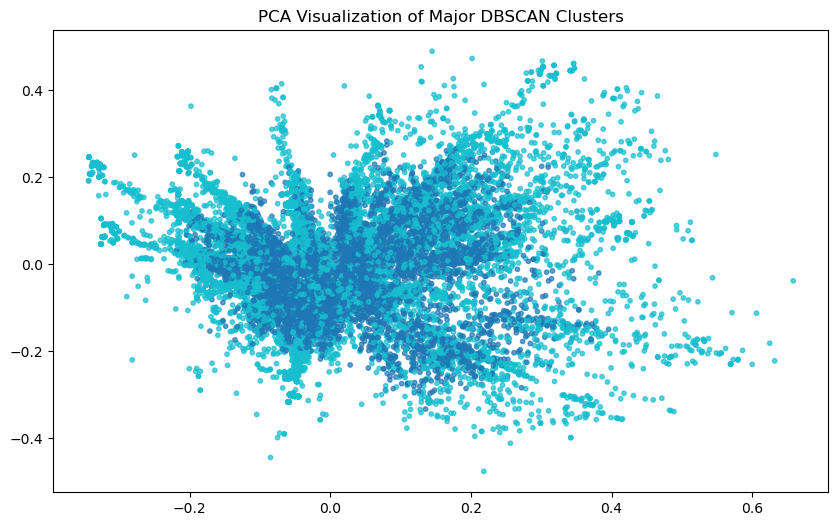

In [23]:
# Keep clusters with at least 50 movies
major_clusters = df["cluster"].value_counts()
major_clusters = major_clusters[major_clusters > 50].index

mask = df["cluster"].isin(major_clusters)

plt.figure(figsize=(10, 6))
plt.scatter(
    X_pca[mask, 0],
    X_pca[mask, 1],
    c=df.loc[mask, "cluster"],
    cmap="tab10",
    s=10,
    alpha=0.7
)
plt.title("PCA Visualization of Major DBSCAN Clusters")
plt.show()


# Save the model & objects

In [25]:
import joblib

# Save DBSCAN model
joblib.dump(dbscan, "dbscan_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save movie dataframe (with clusters)
joblib.dump(df, "movies_df.pkl")

# Save TF-IDF matrix
joblib.dump(X, "tfidf_matrix.pkl")

print("Model and files saved successfully")


Model and files saved successfully


# load model for inference 

In [26]:
import joblib

# Load saved objects
dbscan = joblib.load("dbscan_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")
df = joblib.load("movies_df.pkl")
X = joblib.load("tfidf_matrix.pkl")

print("Model loaded successfully")


Model loaded successfully


# Inference Function (Movie Recommendation)

In [27]:
def recommend_movies(movie_title, top_n=5):
    # Check if movie exists
    if movie_title not in df["title"].values:
        return "Movie not found in dataset"

    # Get cluster of the movie
    cluster_id = df.loc[df["title"] == movie_title, "cluster"].values[0]

    # Handle outliers
    if cluster_id == -1:
        return "This movie is unique. No similar recommendations."

    # Get movies from same cluster
    recommendations = df[
        (df["cluster"] == cluster_id) &
        (df["title"] != movie_title)
    ]["title"].head(top_n)

    return recommendations.tolist()


In [28]:
# call the inference 
recommend_movies("Toy Story (1995)")


['Jumanji (1995)',
 'Waiting to Exhale (1995)',
 'Heat (1995)',
 'Sabrina (1995)',
 'Tom and Huck (1995)']

Project overview
I built a movie recommendation system using unsupervised learning.
The goal was to recommend similar movies without using user ratings.

Dataset
I used the MovieLens movies.csv dataset.
It contains movie titles and genres only.

Approach
First, I combined movie titles and genres into one text field.
Then I converted this text into numbers using TF-IDF.
To measure similarity between movies, I used cosine distance.
After that, I applied DBSCAN to group similar movies automatically.

Why DBSCAN
I chose DBSCAN because:

It does not need the number of clusters in advance

It can detect outlier movies

It works well for similarity-based grouping

Recommendation logic
If a user selects a movie,
I find its DBSCAN cluster and recommend other movies from the same cluster.
If a movie is an outlier, I treat it as a unique movie.

Visualization
I used PCA only for visualization.
It reduces high-dimensional data to 2D so clusters can be seen.
PCA was not used for training the model.

Validation
I validated the model by manually checking clusters.
For example, all Wallace & Gromit movies were grouped together.
This showed that the model learned meaningful similarity.

Limitations
This system does not use user personalization.
It is best for cold-start recommendation and item-to-item similarity.

Final conclusion
This project shows how unsupervised learning can be used to build a recommendation system when user data is not available.